In [2]:
import os
# torch
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.nn import functional as F
from torch import optim

# torchvision
import torchvision
from torchvision import transforms

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [53]:
# Preset parameters
BATCH_SIZE = 64
learning_rate = 1e-2
keep_prob = 0.7

In [54]:
# Load datasets
# tf = transforms.Compose([transforms.ToTensor(), transforms.Resize((64,64))])  # 转为张量数据，同时resize为64*64
tf = transforms.Compose([transforms.ToTensor(), transforms.Resize([28, 28])])  # 转为张量数据，同时resize为28*28
db = torchvision.datasets.ImageFolder(root = 'data', transform = tf) 

In [55]:
# Chekc info
db

Dataset ImageFolder
    Number of datapoints: 27558
    Root location: data
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=[28, 28], interpolation=bilinear, max_size=None, antialias=None)
           )

In [56]:
# ### Spliting
# unsplit_data, test_data = torch.utils.data.random_split(db, [19290, 8268])
# train_data, val_data = torch.utils.data.random_split(unsplit_data, [12860, 6430])

# # Retrieving
# train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size = BATCH_SIZE, shuffle = True)
# validation_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size = BATCH_SIZE, shuffle = False)
# test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size = BATCH_SIZE, shuffle = False)

In [57]:
### Stratified spliting
from sklearn.model_selection import train_test_split

In [58]:
targets = db.targets

train_idx, test_idx= train_test_split(np.arange(len(targets)), train_size=(0.7*2/3), test_size=0.3, shuffle=True, stratify=targets)
validate_idx = np.setdiff1d(np.arange(len(targets)), np.union1d(train_idx, test_idx))

# train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
# validate_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
# test_sampler = torch.utils.data.SubsetRandomSampler(test_idx)

train_data = torch.utils.data.Subset(db, train_idx)
test_data = torch.utils.data.Subset(db, test_idx)
validate_data = torch.utils.data.Subset(db, validate_idx)

In [59]:
tt = len(train_idx) + len(validate_idx) + len(test_idx)

print(f'''The train dataset: {len(train_idx)},{len(train_idx)/tt:.2f}
The validate dataset: {len(validate_idx)}, {len(validate_idx)/tt:.2f}
The test dataset: {len(test_idx)}, {len(test_idx)/tt:.2f}
total length: {tt}''')

The train dataset: 12860,0.47
The validate dataset: 6430, 0.23
The test dataset: 8268, 0.30
total length: 27558


In [60]:
# 验证拆分结果
len(np.setdiff1d(np.arange(len(targets)), np.union1d(train_idx, test_idx)))

6430

In [61]:
# 验证拆分结果
np.intersect1d(train_idx, test_idx)

array([], dtype=int32)

In [62]:
# train_loader = torch.utils.data.DataLoader(db, batch_size=BATCH_SIZE, sampler=train_sampler)
# validate_loader = torch.utils.data.DataLoader(db, batch_size=BATCH_SIZE, sampler=validate_sampler)
# test_loader = torch.utils.data.DataLoader(db, batch_size=BATCH_SIZE, sampler=test_sampler)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE)
validate_loader = torch.utils.data.DataLoader(validate_data, batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE)

In [63]:
len(db.targets)

27558

In [64]:
len(train_loader.dataset)

12860

In [65]:
# ResNet18
class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResidualBlock, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )

    def forward(self, x):
        out = self.left(x)
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, ResidualBlock, num_classes=2):  # num_classes 10->2
        super(ResNet, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )
        self.layer1 = self.make_layer(ResidualBlock, 64,  2, stride=1)
        self.layer2 = self.make_layer(ResidualBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(ResidualBlock, 256, 2, stride=2)
        self.layer4 = self.make_layer(ResidualBlock, 512, 2, stride=2)
        self.fc = nn.Linear(512, num_classes)

    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)   #strides=[1,1]
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out


def ResNet18():
    return ResNet(ResidualBlock)

In [66]:
model = ResNet18()

In [67]:
#  optimizer & loss function
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
loss_function = nn.CrossEntropyLoss()

In [68]:
def train(
    model,
    data_loader,
    optimizer,
    loss_function,
    epoch,
    log_interval=200    # print out info every 200 batches
):
    model.train()
    for batch_idx, (x, label) in enumerate(data_loader):
        
        optimizer.zero_grad()
        output = model(x)
        loss = loss_function(output, label)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print("Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                epoch, batch_idx*len(x), len(data_loader.dataset),
                100. * batch_idx/len(data_loader), loss.data.item()
                # "batch_idx/len(data_loader)" = 当前的batch index除以batch总数
            ))

In [69]:
def validate(
    model, 
    data_loader,
    loss_function,
    epoch,
    loss_vector,
    accuracy_vector
):
    '''applied at train dataset as well as validate dataset'''
    model.eval()
    loss, correct = 0, 0
    for x, label in data_loader: # retrieve tensor dataset and label
        output = model(x)
        loss += loss_function(output, label).data.item()   # "loss_function" is pre-defined, which should be applied in this section
        pred = output.data.max(1)[1]
        correct += pred.eq(label.data).cpu().sum()
    
    # save cal
    loss /= len(data_loader)
#     print(data_loader.dataset)
    loss_vector.append(loss) # for plotting
    accuracy = 100. * correct.to(torch.float32) / len(data_loader.dataset)
    accuracy_vector.append(accuracy)
    print('Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        loss, correct, len(data_loader.dataset), accuracy
    ))

In [70]:
def main(model, train_loader, validate_loader, optimizer, loss_function, num_epochs):
    lossv, accv = [], []
    train_lossv, train_accv = [], []
    for epoch in range(1, num_epochs+1):
        train(model, train_loader, optimizer, loss_function, epoch)
        print("Train set:")
        validate(model, train_loader, loss_function, epoch, train_lossv, train_accv)
        print("Validate set:")
        validate(model, validate_loader, loss_function, epoch, lossv, accv)
    return {'validate':[lossv, accv], 'train':[train_lossv, train_accv]}

In [71]:
# info_dict = main(model, train_loader, validate_loader, optimizer, loss_function, 50)
info_dict = main(model, train_loader, validate_loader, optimizer, loss_function, 20)

Train Epoch: 1 [0/12860 (0%)]	Loss: 0.793887
Train Epoch: 1 [12000/12860 (100%)]	Loss: 0.082369
Train set:
Average loss: 0.1506, Accuracy: 12206/12860 (95%)

Validate set:
Average loss: 0.1589, Accuracy: 6085/6430 (95%)

Train Epoch: 2 [0/12860 (0%)]	Loss: 0.162016
Train Epoch: 2 [12000/12860 (100%)]	Loss: 0.054965
Train set:
Average loss: 0.1096, Accuracy: 12380/12860 (96%)

Validate set:
Average loss: 0.1296, Accuracy: 6145/6430 (96%)

Train Epoch: 3 [0/12860 (0%)]	Loss: 0.136433
Train Epoch: 3 [12000/12860 (100%)]	Loss: 0.042880
Train set:
Average loss: 0.0989, Accuracy: 12395/12860 (96%)

Validate set:
Average loss: 0.1286, Accuracy: 6154/6430 (96%)

Train Epoch: 4 [0/12860 (0%)]	Loss: 0.111710
Train Epoch: 4 [12000/12860 (100%)]	Loss: 0.034764
Train set:
Average loss: 0.0834, Accuracy: 12494/12860 (97%)

Validate set:
Average loss: 0.1287, Accuracy: 6155/6430 (96%)

Train Epoch: 5 [0/12860 (0%)]	Loss: 0.088515
Train Epoch: 5 [12000/12860 (100%)]	Loss: 0.027115
Train set:
Average l

In [81]:
from matplotlib import font_manager

config = {
    "font.family":'Times New Roman', # sans-serif/serif/cursive/fantasy/monospace
    "font.size": 15, # medium/large/small
    'font.style':'normal', # normal/italic/oblique
    'font.weight':'normal', # bold
    "mathtext.fontset":'cm',# 'cm' (Computer Modern)
    "font.serif": ['cmb10'], # 'Simsun'宋体
    "axes.unicode_minus": False,# 用来正常显示负号
}

# plot
def EA_curve(train_loss_vector, validate_loss_vector, train_acc_vector, validate_acc_vector, num_epochs):
    plt.figure(figsize=(5, 3))
    plt.rcParams.update(config)
    plt.plot(np.arange(1, num_epochs+1), train_loss_vector, label="Train error", color='r')
    plt.plot(np.arange(1, num_epochs+1), validate_loss_vector, label="Validation error", color='blue')
    plt.title("Error")
    plt.legend(loc="best")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    
    plt.figure(figsize=(5,3))
    plt.plot(np.arange(1,num_epochs+1), train_acc_vector,label="Train accuracy", color='r')
    plt.plot(np.arange(1,num_epochs+1), validate_acc_vector,label="Validation accuracy", color='blue')
    plt.title('Accuracy')
    plt.legend(loc = "best")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

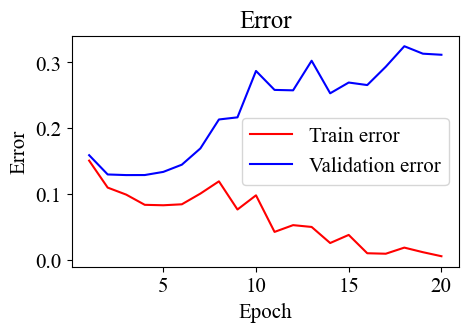

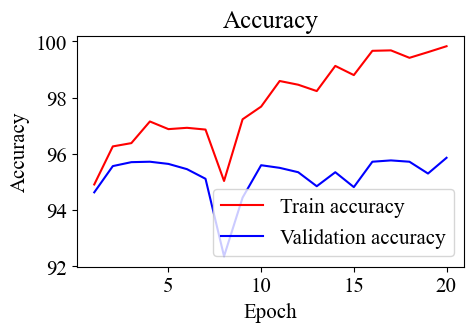

In [82]:
EA_curve(info_dict['train'][0], info_dict['validate'][0], info_dict['train'][1], info_dict['validate'][1], 20)

In [74]:
info_dict['validate'][0]

[0.1588760218997993,
 0.1295646803803963,
 0.1286172537999873,
 0.12868428205388902,
 0.1334761469163886,
 0.14444230670123223,
 0.16918016526511512,
 0.21321335026998958,
 0.21644347649004822,
 0.2870068361360551,
 0.2581876859398522,
 0.2575381774911578,
 0.3025525664719914,
 0.2530408703937025,
 0.2694072206377854,
 0.26556291576981483,
 0.29346559137051337,
 0.32464309827945287,
 0.31329615329136373,
 0.31165257808508684]

In [75]:
# accuracy calculation
# !!! it requires the input object still possessing the "data" and "targets" attributes
def accuracyCal(model, test_data):
    model.eval()
    output = model(test_data.data/255)
    pred = output.data.max(1)[1]
    accuracy = pred.eq(test_data.targets).cpu().sum().to(torch.float32) / len(test_data)
    print(accuracy)

In [76]:
# type(test_data)
# accuracyCal(model, test_data)

In [77]:
# accuracy calculation
model.eval()
correct = 0
total = 0
for images, labels in test_loader:
    images = images.float()
    outputs = model(images).cpu()
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy：%.2f%%' % (100 * correct / total))

Accuracy：95.71%


In [83]:
# Save trained model
# torch.save(model.state_dict(), 'results/LeNet5-cellimage.pkl')
torch.save(model, 'results/ResNet18-lrle-2-cellimage.pkl')
# model_re = torch.load('results/LeNet5-cellimage.pkl')